In [11]:
import sys
import os

# Add ROOT/model path to load own modules
model_path = os.path.normpath(os.path.join(os.getcwd(), *[os.pardir]*2, "model"))
sys.path.insert(0, model_path)

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation, Lambda, InputLayer
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from kerastuner.tuners import RandomSearch
from tensorflow.keras import metrics
from keras.callbacks import TensorBoard, EarlyStopping

import matplotlib.pyplot as plt
# from keras import metrics
import pandas as pd
# from reproduce import reproduce
import numpy as np
# from tensorboard.plugins.hparams import api as hp
import tensorflow as tf
from utils import get_data, plot_predicted_vs_true, custom_r2, custom_adj_r2, ROOT_DIR
from datetime import datetime
from shutil import rmtree
import os
import sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
TRAINING = True
CLEAN = False

if len(sys.argv) > 1:
    if sys.argv[1] == "train":
        TRAINING = True
    if sys.argv[1] == "clean":
        CLEAN = True


In [14]:
begin = datetime.now()
# This set seeds to make the result reproducible
# reproduce(0)


tensorboard = TensorBoard(log_dir=ROOT_DIR + "/logs/")

# read in data using pandas

X_train, Y_train, X_validation, Y_validation, X_test, Y_test = get_data()

# get number of columns in training data
#validation_split_rate = 0.2
#n_units_of_N_layer = 128
n_cols = X_train.shape[1]
#train_total = X_train.shape[0]
#batch_size = int(np.floor((1 - validation_split_rate) * train_total))

In [15]:
[0.01 / 2**val for val in range(6)]

[0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125]

In [16]:
def build_model(hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(n_cols,)))

    num_units_per_layer = hp.Int('units_per_hidden_layer', min_value=32,
                                 max_value=4096, step=32)
    dropout_rate_per_layer = hp.Float('dropout_per_hidden_layer', min_value=0.0,
                                      max_value=0.9, step=0.1, default=0.5)

    for i in range(hp.Choice('num_layers', values=[1])):
        model.add(Dense(units=num_units_per_layer,
                        kernel_initializer='he_uniform',
                        bias_initializer='zeros'))
        model.add(BatchNormalization())
        model.add(Activation("relu"))
        model.add(Dropout(rate=dropout_rate_per_layer))

    model.add(Dense(1, 
                    kernel_initializer='he_uniform',
                    bias_initializer='zeros'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    
    model.compile(optimizer=Adam(hp.Choice('learning_rate',
                                           values=[0.01, 0.005, 0.0025, 0.00125, 0.000625, 0.0003125])),
                  loss='mean_squared_error',
                  metrics=[metrics.RootMeanSquaredError(), metrics.MeanAbsoluteError(), metrics.MeanAbsolutePercentageError(), metrics.MeanSquaredLogarithmicError()])
    return model

In [17]:
max_trial = 1000

In [18]:
tuner = RandomSearch(
    build_model,
    seed=0,
    objective="val_loss",
    max_trials=max_trial,
    executions_per_trial=3,
    directory=ROOT_DIR + "/random-search",
    project_name="covid-19-nn")

if TRAINING:
    tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project /all/random-search/covid-19-nn/oracle.json
INFO:tensorflow:Reloading Tuner from /all/random-search/covid-19-nn/tuner0.json


In [19]:
early_stopping_monitor = EarlyStopping(monitor="val_loss", patience=100)
# Use .values to convert pandas dataframe to numpy array
# To avoid the Warning -> WARNING:tensorflow:Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
tuner.search(X_train.values, Y_train.values,
             epochs=10000,
             batch_size=96,
             validation_data=(X_validation.values, Y_validation.values),
             verbose=0,
             callbacks=[early_stopping_monitor])

INFO:tensorflow:Oracle triggered exit


In [ ]:
if CLEAN:
    # all other trial_ids than top 3
    trial_ids_to_remove = [best_trial.trial_id for best_trial in tuner.oracle.get_best_trials(
        num_trials=max_trial)[3:]]

    for trial_id in trial_ids_to_remove:
        rsPath = ROOT_DIR + "/random-search/covid-19-nn/trial_{}".format(trial_id)
        logsPath = ROOT_DIR + "/logs/{}".format(trial_id)
        if os.path.isdir(rsPath):
            rmtree(rsPath)
        if os.path.isdir(logsPath):
            rmtree(logsPath)

######## GET BEST MODELS ########
5/5 [==============================] - ETA: 0s - loss: 0.4989 - root_mean_squared_error: 0.7064 - mean_absolute_error: 0.4897 - mean_absolute_percentage_error: 3693531.2500 - mean_squared_logarithmic_error: 0.113 - 0s 4ms/step - loss: 0.4887 - root_mean_squared_error: 0.6991 - mean_absolute_error: 0.4648 - mean_absolute_percentage_error: 3791113.2500 - mean_squared_logarithmic_error: 0.1093
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)       

None
R2: 0.27664662077677793
Adj. R2: 0.1876185125646891
######## SUMMARY ########
Overall Runtime: 0:25:33.432705
1/1 [==============================] - ETA: 0s - loss: 0.4887 - root_mean_squared_error: 0.6991 - mean_absolute_error: 0.4648 - mean_absolute_percentage_error: 3791112.7500 - mean_squared_logarithmic_error: 0.109 - 0s 4ms/step - loss: 0.4887 - root_mean_squared_error: 0.6991 - mean_absolute_error: 0.4648 - mean_absolute_percentage_error: 3791112.7500 - mean_squared_logarithmic_error: 0.1093


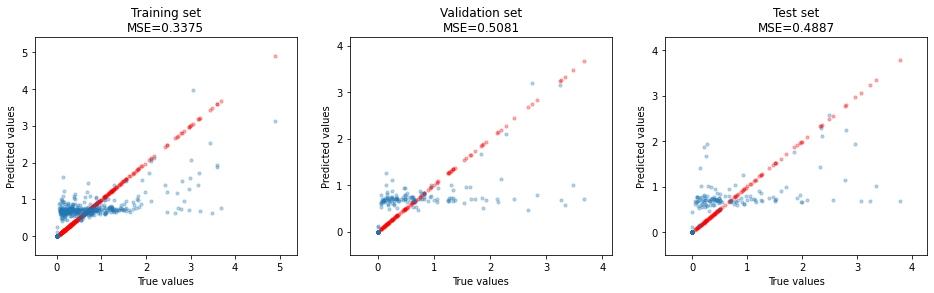

INFO:tensorflow:Assets written to: /all/best-models/one-hidden-layer-2/assets


In [26]:
print("######## GET BEST MODELS ########")
models = tuner.get_best_models()
evaluation = models[0].evaluate(X_test.values, Y_test.values)
print(models[0].summary())
print(evaluation)
print("Mean Squared Error", evaluation[1])

print(tuner.results_summary(1))

print("R2:", custom_r2(evaluation[0], Y_test.to_numpy()))
print("Adj. R2:", custom_adj_r2(evaluation[0], Y_test.to_numpy(), 16))

print("######## SUMMARY ########")
print("Overall Runtime:", datetime.now() - begin)

# if not TRAINING and not CLEAN:
plot_predicted_vs_true(Xs=[X_train, X_validation, X_test],
                       Ys=[Y_train, Y_validation, Y_test],
                       model=models[0])

# # Save the best model
models[0].save(ROOT_DIR + "/best-models/one-hidden-layer-2")


# # Instantiate a model with the best hyperparameters -> makes the model retrainable
# best_hp = tuner.get_best_hyperparameters()[0]
# mode_of_best_hp = tuner.hypermodel.build(best_hp)
# print(mode_of_best_hp.evaluate(X_test, Y_test))
# mode_of_best_hp.fit(X_train, Y_train, batch_size=train_total, validation_data=(X_validation, Y_validation),
#           epochs=1000, verbose=1, callbacks=[])


In [21]:
# Instantiate a model with the best hyperparameters -> makes the model retrainable
best_hp = tuner.get_best_hyperparameters()[0]
mode_of_best_hp = tuner.hypermodel.build(best_hp)
print(mode_of_best_hp.evaluate(X_test, Y_test))


5/5 [==============================] - ETA: 0s - loss: 0.9198 - root_mean_squared_error: 0.9591 - mean_absolute_error: 0.7329 - mean_absolute_percentage_error: 265288.9062 - mean_squared_logarithmic_error: 0.20 - 0s 10ms/step - loss: 1.1096 - root_mean_squared_error: 1.0534 - mean_absolute_error: 0.7369 - mean_absolute_percentage_error: 3986315.7500 - mean_squared_logarithmic_error: 0.2607
[1.1096388101577759, 1.0533939599990845, 0.7369298338890076, 3986315.75, 0.26072609424591064]


In [ ]:
history = mode_of_best_hp.fit(X_train, Y_train, batch_size=96, validation_data=(X_validation, Y_validation),
          epochs=1000, verbose=2, callbacks=[early_stopping_monitor])

In [ ]:
history.history

In [25]:
tuner.load_model("15d27359394dd5e84b5b970d8260c7b4")

AttributeError: 'str' object has no attribute 'hyperparameters'